In [ ]:
!pip install -q tensorflow matplotlib opencv-python scikit-learn tqdm

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

# Random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Download GTSRB dataset
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

# Extract the datasets
!unzip -q GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Test_Images.zip
!unzip -q GTSRB_Final_Test_GT.zip

# Define paths
train_path = 'GTSRB/Final_Training/Images/'
test_path = 'GTSRB/Final_Test/Images/'

--2025-06-16 12:43:09--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  25.4MB/s    in 11s     

2025-06-16 12:43:21 (24.0 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

--2025-06-16 12:43:21--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.8

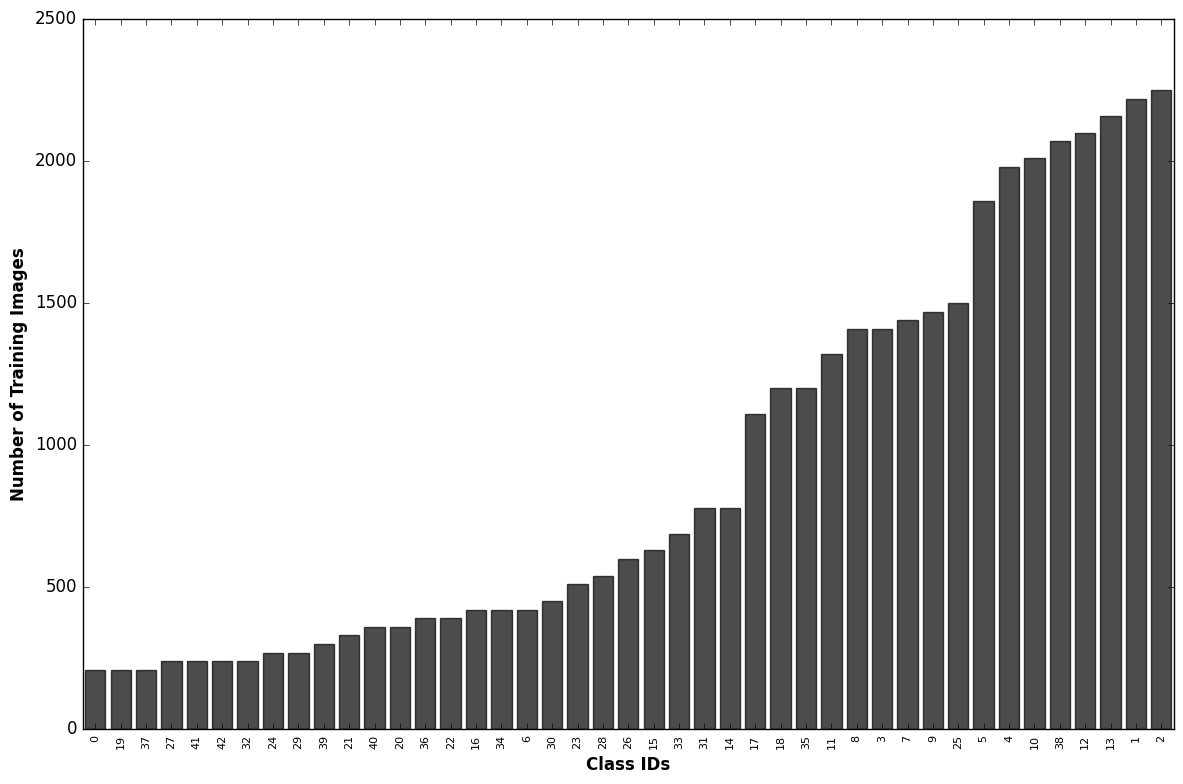

Least represented class: Speed limit (20km/h) (ID: 0) with 210 images
Most represented class: Speed limit (50km/h) (ID: 2) with 2250 images
Imbalance ratio (most/least): 10.71x


In [ ]:
# Check dataset class distribution
class_counts = {}
class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at intersection", 12: "Priority road", 13: "Yield", 14: "Stop",
    15: "No vehicles", 16: "Vehicles over 3.5 tons prohibited", 17: "No entry",
    18: "General caution", 19: "Dangerous curve left", 20: "Dangerous curve right",
    21: "Double curve", 22: "Bumpy road", 23: "Slippery road", 24: "Road narrows on the right",
    25: "Road work", 26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead", 34: "Turn left ahead",
    35: "Ahead only", 36: "Go straight or right", 37: "Go straight or left", 38: "Keep right",
    39: "Keep left", 40: "Roundabout mandatory", 41: "End of no passing",
    42: "End no passing veh > 3.5 tons"
}

# Count samples per class
for c in range(43):
    prefix = os.path.join(train_path, f'{c:05d}/')
    gt_file = os.path.join(prefix, f'GT-{c:05d}.csv')
    gt_data = pd.read_csv(gt_file, sep=';')
    class_counts[c] = len(gt_data)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'class_id': list(class_counts.keys()),
    'count': list(class_counts.values()),
    'class_name': [class_names[c] for c in class_counts.keys()]
})

# Sort by count (ascending)
df = df.sort_values('count')

# Show the plot
plt.figure(figsize=(12, 8))
plt.style.use('classic')
x_positions = np.arange(len(df))
bars = plt.bar(x_positions, df['count'], color='black', edgecolor='black', alpha=0.7, width=0.8)
plt.xlabel('Class IDs', fontsize=12, fontweight='bold')
plt.ylabel('Number of Training Images', fontsize=12, fontweight='bold')
plt.xticks(x_positions, df['class_id'], rotation=90, fontsize=8)
plt.xlim(-0.5, len(df)-0.5)
plt.grid(False)
plt.tight_layout()
plt.tight_layout()
plt.savefig('gtsrb_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Least represented class: {df.iloc[0]['class_name']} (ID: {df.iloc[0]['class_id']}) with {df.iloc[0]['count']} images")
print(f"Most represented class: {df.iloc[-1]['class_name']} (ID: {df.iloc[-1]['class_id']}) with {df.iloc[-1]['count']} images")
print(f"Imbalance ratio (most/least): {df.iloc[-1]['count'] / df.iloc[0]['count']:.2f}x")

In [ ]:
# Print the number of images for each class
print("Number of images per class:\n")
for _, row in df.iterrows():
    print(f"Class ID {row['class_id']:2d} - {row['class_name']:<45}: {row['count']} images")


Number of images per class:

Class ID  0 - Speed limit (20km/h)                         : 210 images
Class ID 19 - Dangerous curve left                         : 210 images
Class ID 37 - Go straight or left                          : 210 images
Class ID 27 - Pedestrians                                  : 240 images
Class ID 41 - End of no passing                            : 240 images
Class ID 42 - End no passing veh > 3.5 tons                : 240 images
Class ID 32 - End of all speed and passing limits          : 240 images
Class ID 24 - Road narrows on the right                    : 270 images
Class ID 29 - Bicycles crossing                            : 270 images
Class ID 39 - Keep left                                    : 300 images
Class ID 21 - Double curve                                 : 330 images
Class ID 40 - Roundabout mandatory                         : 360 images
Class ID 20 - Dangerous curve right                        : 360 images
Class ID 36 - Go straight or right 


                   GTSRB CLASS-AWARE DATA AUGMENTATION STRATEGY

Class IDClass Name                                   Original  Strategy                      Added     Final     
----------------------------------------------------------------------------------------------------
0       Speed limit (20km/h)                         210       3 techniques per image        630       840       
19      Dangerous curve left                         210       3 techniques per image        630       840       
37      Go straight or left                          210       3 techniques per image        630       840       
27      Pedestrians                                  240       3 techniques per image        720       960       
41      End of no passing                            240       3 techniques per image        720       960       
42      End no passing veh > 3.5 tons                240       3 techniques per image        720       960       
32      End of all speed and passin

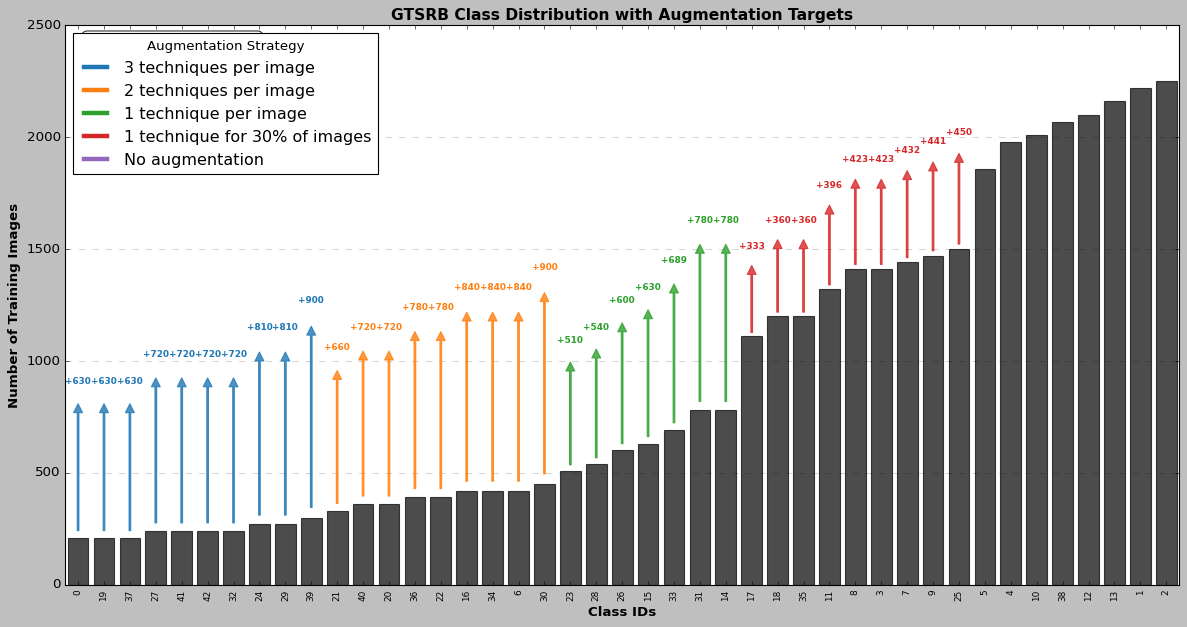

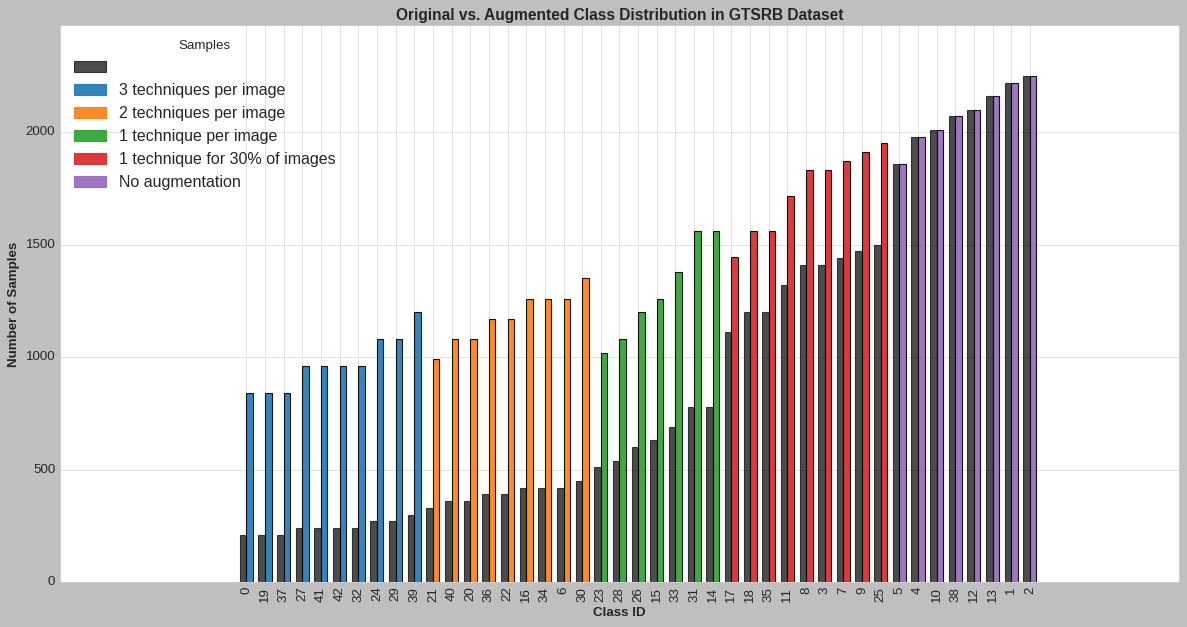


                       AUGMENTATION STRATEGY SUMMARY

1 technique for 30% of images (9 classes):
  Class IDs: 3, 7, 8, 9, 11, 17, 18, 25, 35

1 technique per image (7 classes):
  Class IDs: 14, 15, 23, 26, 28, 31, 33

2 techniques per image (9 classes):
  Class IDs: 6, 16, 20, 21, 22, 30, 34, 36, 40

3 techniques per image (10 classes):
  Class IDs: 0, 19, 24, 27, 29, 32, 37, 39, 41, 42

No augmentation (8 classes):
  Class IDs: 1, 2, 4, 5, 10, 12, 13, 38

--------------------------------------------------------------------------------
OVERALL STATISTICS:
Total images before augmentation: 39,209
Total images after augmentation: 61,726
Increase: 22,517 images (+57.4%)

--------------------------------------------------------------------------------
STRATEGY EFFECTIVENESS:
Strategy                      Classes   Before    After     Increase  Percent   
--------------------------------------------------------------------------------
3 techniques per image        10        2430      9720 

In [ ]:
class_counts = {
    0: 210, 19: 210, 37: 210, 27: 240, 41: 240, 42: 240, 32: 240, 24: 270, 29: 270, 39: 300,
    21: 330, 40: 360, 20: 360, 36: 390, 22: 390, 16: 420, 34: 420, 6: 420, 30: 450,
    23: 510, 28: 540, 26: 600, 15: 630, 33: 689, 31: 780, 14: 780,
    17: 1110, 18: 1200, 35: 1200, 11: 1320, 8: 1410, 3: 1410, 7: 1440, 9: 1470, 25: 1500,
    5: 1860, 4: 1980, 10: 2010, 38: 2070, 12: 2100, 13: 2160, 1: 2220, 2: 2250
}

class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at intersection", 12: "Priority road", 13: "Yield", 14: "Stop",
    15: "No vehicles", 16: "Vehicles over 3.5 tons prohibited", 17: "No entry",
    18: "General caution", 19: "Dangerous curve left", 20: "Dangerous curve right",
    21: "Double curve", 22: "Bumpy road", 23: "Slippery road", 24: "Road narrows on the right",
    25: "Road work", 26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead", 34: "Turn left ahead",
    35: "Ahead only", 36: "Go straight or right", 37: "Go straight or left", 38: "Keep right",
    39: "Keep left", 40: "Roundabout mandatory", 41: "End of no passing",
    42: "End no passing veh > 3.5 tons"
}

# Define augmentation strategy based on class count
def get_augmentation_strategy(count):
    if count <= 300:
        return "3 techniques per image", count * 3
    elif count <= 450:
        return "2 techniques per image", count * 2
    elif count <= 780:
        return "1 technique per image", count
    elif count <= 1500:
        return "1 technique for 30% of images", int(count * 0.3)
    else:
        return "No augmentation", 0

# Create DataFrame with augmentation strategy
data = []
for class_id, count in class_counts.items():
    strategy, added = get_augmentation_strategy(count)
    final_count = count + added

    data.append({
        'class_id': class_id,
        'class_name': class_names[class_id],
        'original_count': count,
        'augmentation_strategy': strategy,
        'added_samples': added,
        'final_count': final_count
    })

df = pd.DataFrame(data)
df = df.sort_values('original_count')

# Create a color map for different strategies
strategy_colors = {
    "3 techniques per image": "#1f77b4",       # blue
    "2 techniques per image": "#ff7f0e",       # orange
    "1 technique per image": "#2ca02c",        # green
    "1 technique for 30% of images": "#d62728", # red
    "No augmentation": "#9467bd"               # purple
}

# Calculate total images before and after
total_before = df['original_count'].sum()
total_after = df['final_count'].sum()

# -------------------------------------------------
# 1. Create clean table
# -------------------------------------------------
print("\n" + "="*80)
print("                   GTSRB CLASS-AWARE DATA AUGMENTATION STRATEGY")
print("="*80)

# Display the data in a formatted table
print(f"\n{'Class ID':<8}{'Class Name':<45}{'Original':<10}{'Strategy':<30}{'Added':<10}{'Final':<10}")
print("-"*100)

for _, row in df.iterrows():
    print(f"{row['class_id']:<8}{row['class_name']:<45}{row['original_count']:<10}{row['augmentation_strategy']:<30}{row['added_samples']:<10}{row['final_count']:<10}")

# -------------------------------------------------
# 2. Create graph with arrows showing augmentation targets
# -------------------------------------------------
plt.figure(figsize=(15, 8))
plt.style.use('classic')

x_positions = np.arange(len(df))

# Create bars for original distribution (black as requested)
bars = plt.bar(x_positions, df['original_count'], color='black', edgecolor='black', alpha=0.7, width=0.8)

# Add labels and title
plt.xlabel('Class IDs', fontsize=12, fontweight='bold')
plt.ylabel('Number of Training Images', fontsize=12, fontweight='bold')
plt.title('GTSRB Class Distribution with Augmentation Targets', fontsize=14, fontweight='bold')
plt.xticks(x_positions, df['class_id'], rotation=90, fontsize=8)
plt.xlim(-0.5, len(df)-0.5)

# Draw arrows pointing to augmentation targets for classes that will be augmented
for i, row in df.iterrows():
    if row['added_samples'] > 0:
        # Choose color based on strategy
        color = strategy_colors[row['augmentation_strategy']]

        # Calculate arrow starting and ending points
        start_x = x_positions[i]
        start_y = row['original_count']
        end_y = row['final_count']

        # Add arrow
        plt.annotate('',
                    xy=(start_x, end_y),
                    xytext=(start_x, start_y),
                    arrowprops=dict(facecolor=color, edgecolor=color, width=1.5,
                                   shrink=0.05, alpha=0.8,
                                   headwidth=8, headlength=8))

        # Add text indicating the strategy and final count
        plt.text(start_x, end_y + 50, f"+{row['added_samples']}",
                color=color, ha='center', va='bottom', fontsize=8, fontweight='bold')

# Create a custom legend for strategies
legend_elements = []
for strategy, color in strategy_colors.items():
    if strategy in df['augmentation_strategy'].values:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=strategy))

plt.legend(handles=legend_elements, loc='upper left', title="Augmentation Strategy")

# Add annotations for imbalance statistics
plt.annotate(f"Before: max/min ratio = {df['original_count'].max() / df['original_count'].min():.1f}x",
            xy=(0.02, 0.98), xycoords='axes fraction',
            fontsize=10, ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.annotate(f"After: max/min ratio = {df['final_count'].max() / df['final_count'].min():.1f}x",
            xy=(0.02, 0.93), xycoords='axes fraction',
            fontsize=10, ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('gtsrb_augmentation_targets.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# 3. Create separate bar chart showing before/after
# -------------------------------------------------
plt.figure(figsize=(15, 8))
plt.style.use('seaborn-v0_8-whitegrid')

x = np.arange(len(df))
width = 0.35

# Create bars for original count
bars1 = plt.bar(x - width/2, df['original_count'], width, label='Original Samples',
              color='black', edgecolor='black', alpha=0.7)

# Create bars for augmented count with strategy-based colors
bars2 = plt.bar(x + width/2, df['final_count'], width, label='After Augmentation',
              color=[strategy_colors[s] for s in df['augmentation_strategy']],
              edgecolor='black', alpha=0.9)

# Customize the plot
plt.xlabel('Class ID', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Original vs. Augmented Class Distribution in GTSRB Dataset', fontsize=14, fontweight='bold')

# Set x-ticks to class IDs
plt.xticks(x, df['class_id'], rotation=90)
plt.ylim(0, df['final_count'].max() * 1.1)

# Create a custom legend for strategies
legend_handles = []
for strategy, color in strategy_colors.items():
    if strategy in df['augmentation_strategy'].values:
        legend_handles.append(plt.Rectangle((0,0), 1, 1, color=color, label=strategy, alpha=0.9))

plt.legend(handles=[plt.Rectangle((0,0), 1, 1, color='black', alpha=0.7)] + legend_handles,
           loc='upper left', title="Samples")

plt.tight_layout()
plt.savefig('class_distribution_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------
# 4. Print clear summary statistics
# -------------------------------------------------
print("\n" + "="*80)
print("                       AUGMENTATION STRATEGY SUMMARY")
print("="*80)

# Strategy counts
strategy_counts = df['augmentation_strategy'].value_counts().sort_index()
for strategy, count in strategy_counts.items():
    class_ids = df[df['augmentation_strategy'] == strategy]['class_id'].tolist()
    class_ids_str = ', '.join(map(str, sorted(class_ids)))
    print(f"\n{strategy} ({count} classes):")
    print(f"  Class IDs: {class_ids_str}")

# Overall statistics
print("\n" + "-"*80)
print("OVERALL STATISTICS:")
print(f"Total images before augmentation: {total_before:,}")
print(f"Total images after augmentation: {total_after:,}")
print(f"Increase: {total_after - total_before:,} images (+{(total_after / total_before - 1) * 100:.1f}%)")

# Strategy effectiveness
print("\n" + "-"*80)
print("STRATEGY EFFECTIVENESS:")
print(f"{'Strategy':<30}{'Classes':<10}{'Before':<10}{'After':<10}{'Increase':<10}{'Percent':<10}")
print("-"*80)

for strategy in strategy_colors.keys():
    if strategy in df['augmentation_strategy'].values:
        subset = df[df['augmentation_strategy'] == strategy]
        before = subset['original_count'].sum()
        after = subset['final_count'].sum()
        increase = after - before
        increase_pct = (after/before - 1) * 100
        print(f"{strategy:<30}{len(subset):<10}{before:<10}{after:<10}{increase:<10}{increase_pct:.1f}%")

# Balance improvement
print("\n" + "-"*80)
print("CLASS IMBALANCE ANALYSIS:")
max_class_before = df['original_count'].max()
min_class_before = df['original_count'].min()
max_class_after = df['final_count'].max()
min_class_after = df['final_count'].min()

print(f"Before augmentation: max/min ratio = {max_class_before / min_class_before:.1f}x ({max_class_before} / {min_class_before})")
print(f"After augmentation: max/min ratio = {max_class_after / min_class_after:.1f}x ({max_class_after} / {min_class_after})")
print(f"Imbalance reduction: {(1 - (max_class_after / min_class_after) / (max_class_before / min_class_before)) * 100:.1f}%")

In [ ]:
def rotate_image(image, angle_range=(-15, 15)):
    """
    Rotate an image by a random angle within the specified range.

    Args:
        image: Input image (numpy array)
        angle_range: Tuple of (min_angle, max_angle) in degrees

    Returns:
        Rotated image
    """
    # Get random angle within range
    angle = np.random.uniform(angle_range[0], angle_range[1])

    # Get image dimensions
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height),
                                  flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return rotated_image

def shear_image(image, shear_range=(-0.2, 0.2)):
    """
    Apply shear transformation to an image.

    Args:
        image: Input image (numpy array)
        shear_range: Tuple of (min_shear, max_shear) factor

    Returns:
        Sheared image
    """
    # Get random shear factor
    shear_factor = np.random.uniform(shear_range[0], shear_range[1])

    # Get image dimensions
    height, width = image.shape[:2]

    # Create shear matrix
    shear_matrix = np.array([[1, shear_factor, 0],
                             [0, 1, 0]])

    # Apply shear transformation
    sheared_image = cv2.warpAffine(image, shear_matrix, (width, height),
                                  flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return sheared_image

def gamma_correction(image, gamma_range=(0.4, 1.5)):
    """
    Apply gamma correction to adjust image brightness/contrast.

    Args:
        image: Input image (numpy array) with values in [0, 1]
        gamma_range: Tuple of (min_gamma, max_gamma)

    Returns:
        Gamma-corrected image
    """
    # Get random gamma value
    gamma = np.random.uniform(gamma_range[0], gamma_range[1])

    # Ensure image is in float format
    if image.dtype != np.float32 and image.dtype != np.float64:
        image_float = image.astype(np.float32) / 255.0
    else:
        image_float = image.copy()

    # Apply gamma correction
    corrected = np.power(image_float, gamma)

    # Scale back to original range if needed
    if image.dtype != np.float32 and image.dtype != np.float64:
        corrected = np.clip(corrected * 255.0, 0, 255).astype(image.dtype)
    else:
        # Normalize to keep values between 0 and 1
        corrected = corrected / np.max(corrected)

    return corrected

def translate_image(image, translate_range=(-5, 5)):
    """
    Translate (shift) an image horizontally and vertically.

    Args:
        image: Input image (numpy array)
        translate_range: Tuple of (min_shift, max_shift) in pixels

    Returns:
        Translated image
    """
    # Get random translation values
    tx = np.random.uniform(translate_range[0], translate_range[1])
    ty = np.random.uniform(translate_range[0], translate_range[1])

    # Get image dimensions
    height, width = image.shape[:2]

    # Create translation matrix
    translation_matrix = np.array([[1, 0, tx],
                                  [0, 1, ty]])

    # Apply translation
    translated_image = cv2.warpAffine(image, translation_matrix, (width, height),
                                     flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return translated_image

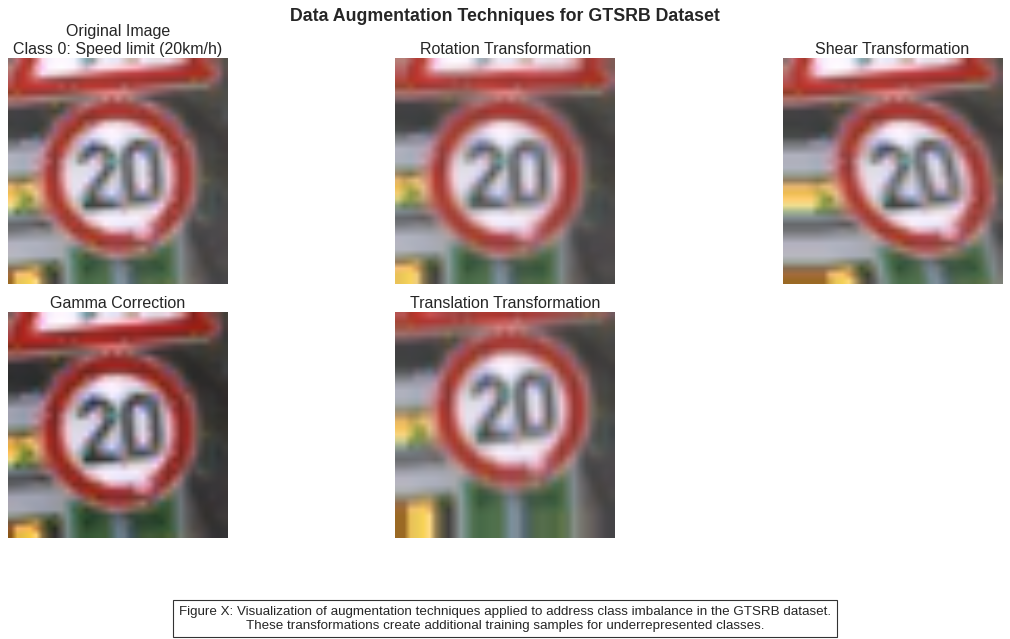

Figure saved as 'gtsrb_augmentation_examples.png'


In [ ]:
# Load and display augmentation examples for a research paper
import matplotlib.pyplot as plt

# Choose a class with fewer samples (Class 0: Speed limit 20km/h)
class_id = 0
sample_class = f"{class_id:05d}"
sample_img_path = f"{train_path}{sample_class}/00000_00010.ppm"

# Load original image
orig_img = cv2.imread(sample_img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# Apply each transformation
rotated_img = rotate_image(orig_img, angle_range=(-15, 15))
sheared_img = shear_image(orig_img, shear_range=(-0.2, 0.2))
gamma_img = gamma_correction(orig_img, gamma_range=(0.5, 1.5))
translated_img = translate_image(orig_img, translate_range=(-5, 5))

# Create figure with all transformations
plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 12})

# Original image
plt.subplot(2, 3, 1)
plt.title("Original Image\nClass 0: Speed limit (20km/h)")
plt.imshow(orig_img)
plt.axis('off')

# Rotation
plt.subplot(2, 3, 2)
plt.title("Rotation Transformation")
plt.imshow(rotated_img)
plt.axis('off')

# Shear
plt.subplot(2, 3, 3)
plt.title("Shear Transformation")
plt.imshow(sheared_img)
plt.axis('off')

# Gamma correction
plt.subplot(2, 3, 4)
plt.title("Gamma Correction")
plt.imshow(gamma_img)
plt.axis('off')

# Translation
plt.subplot(2, 3, 5)
plt.title("Translation Transformation")
plt.imshow(translated_img)
plt.axis('off')

# Add main title
plt.suptitle("Data Augmentation Techniques for GTSRB Dataset", fontsize=16, fontweight='bold', y=0.98)

# Add descriptive text at bottom
plt.figtext(0.5, 0.01,
           "Figure X: Visualization of augmentation techniques applied to address class imbalance in the GTSRB dataset.\nThese transformations create additional training samples for underrepresented classes.",
           ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)

# Save high-resolution figure for research paper
plt.savefig('gtsrb_augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'gtsrb_augmentation_examples.png'")

In [ ]:
# Cell 1: Define preprocessing function for GTSRB images
def preprocess_image(image_path, img_size=32):
    """
    Load and preprocess an image from the GTSRB dataset:
    - Resize to 32x32
    - Convert to grayscale
    - Normalize pixel values

    Args:
        image_path: Path to the image file
        img_size: Target size for width and height

    Returns:
        Preprocessed image as numpy array
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Resize image
    img = cv2.resize(img, (img_size, img_size))

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize pixel values to [0, 1]
    img = img / 255.0

    # Add channel dimension for model compatibility
    img = np.expand_dims(img, axis=-1)

    return img

In [ ]:
# Cell 2: Define augmentation strategy based on class count
def apply_augmentation_strategy(images, labels, class_id, class_count):
    """
    Apply class-aware augmentation strategy:
    - ≤300 samples: 3 techniques per image
    - 301-450 samples: 2 techniques per image
    - 451-780 samples: 1 technique per image
    - 781-1500 samples: 1 technique for 30% of images
    - >1500 samples: No augmentation

    Args:
        images: List of original images for this class
        labels: List of labels for this class
        class_id: Class ID
        class_count: Number of original samples in this class

    Returns:
        Augmented images and labels
    """
    augmented_images = []
    augmented_labels = []

    # Define transformation functions
    transforms = [
        lambda img: rotate_image(img, angle_range=(-15, 15)),
        lambda img: shear_image(img, shear_range=(-0.2, 0.2)),
        lambda img: gamma_correction(img, gamma_range=(0.5, 1.5)),
        lambda img: translate_image(img, translate_range=(-3, 3))
    ]

    # Apply strategy based on class count
    if class_count <= 300:
        # Apply 3 techniques per image
        print(f"Class {class_id}: Applying 3 techniques per image")
        for img in images:
            # Randomly select 3 transforms without replacement
            selected_transforms = np.random.choice(transforms, 3, replace=False)
            for transform in selected_transforms:
                aug_img = transform(img)
                if aug_img.ndim == 2:
                    aug_img = np.expand_dims(aug_img, axis=-1)
                augmented_images.append(aug_img)
                augmented_labels.append(class_id)

    elif class_count <= 450:
        # Apply 2 techniques per image
        print(f"Class {class_id}: Applying 2 techniques per image")
        for img in images:
            # Randomly select 2 transforms without replacement
            selected_transforms = np.random.choice(transforms, 2, replace=False)
            for transform in selected_transforms:
                aug_img = transform(img)
                if aug_img.ndim == 2:
                    aug_img = np.expand_dims(aug_img, axis=-1)
                augmented_images.append(aug_img)
                augmented_labels.append(class_id)

    elif class_count <= 780:
        # Apply 1 technique per image
        print(f"Class {class_id}: Applying 1 technique per image")
        for img in images:
            # Randomly select 1 transform
            transform = np.random.choice(transforms)
            aug_img = transform(img)
            if aug_img.ndim == 2:
                aug_img = np.expand_dims(aug_img, axis=-1)
            augmented_images.append(aug_img)
            augmented_labels.append(class_id)

    elif class_count <= 1500:
        # Apply 1 technique to 30% of images
        print(f"Class {class_id}: Applying 1 technique to 30% of images")
        # Select 30% of images randomly
        n_augment = int(0.3 * len(images))
        indices_to_augment = np.random.choice(len(images), n_augment, replace=False)

        for idx in indices_to_augment:
            img = images[idx]
            # Randomly select 1 transform
            transform = np.random.choice(transforms)
            aug_img = transform(img)
            if aug_img.ndim == 2:
                aug_img = np.expand_dims(aug_img, axis=-1)
            augmented_images.append(aug_img)
            augmented_labels.append(class_id)
    else:
        # No augmentation for classes with >1500 samples
        print(f"Class {class_id}: No augmentation needed")

    return augmented_images, augmented_labels

In [ ]:
# Cell 3: Load and preprocess the entire GTSRB dataset with augmentation
def load_balanced_dataset():
    """
    Load and preprocess the GTSRB dataset with class-aware augmentation

    Returns:
        X_train, y_train, X_test, y_test: Training and test datasets
    """
    print("Loading and preprocessing GTSRB dataset with augmentation...")

    # Initialize lists for training data
    original_images = []
    original_labels = []
    augmented_images = []
    augmented_labels = []

    # Load training data by class
    for class_id in tqdm(range(43), desc="Processing classes"):
        # Format class folder path
        class_folder = f"{class_id:05d}"
        class_path = os.path.join(train_path, class_folder)

        # Get class sample count
        gt_file = os.path.join(class_path, f'GT-{class_folder}.csv')
        gt_data = pd.read_csv(gt_file, sep=';')
        class_count = len(gt_data) - 1  # Subtract header

        # Class-specific image collection
        class_images = []

        # Process each image in this class
        for idx, row in gt_data.iterrows():
            if idx == 0:  # Skip header
                continue

            # Get image path
            img_name = row.iloc[0] if isinstance(row, pd.Series) else row[0]
            img_path = os.path.join(class_path, img_name)

            # Preprocess image
            img = preprocess_image(img_path)

            # Add to original dataset
            original_images.append(img)
            original_labels.append(class_id)

            # Store for augmentation
            class_images.append(img)

        # Apply augmentation based on class count
        aug_images, aug_labels = apply_augmentation_strategy(
            class_images, [class_id] * len(class_images), class_id, class_count
        )

        # Add augmented images to the dataset
        augmented_images.extend(aug_images)
        augmented_labels.extend(aug_labels)

    # Combine original and augmented data
    X_train = np.array(original_images + augmented_images)
    y_train = np.array(original_labels + augmented_labels)

    # Shuffle the training data
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Load test data
    print("Loading test data...")
    X_test = []
    y_test = []

    # Parse test annotations
    test_gt_path = 'GT-final_test.csv'
    test_annotations = pd.read_csv(test_gt_path, sep=';')

    # Process each test image
    for idx, row in tqdm(test_annotations.iterrows(), desc="Processing test images"):
        if idx == 0:  # Skip header
            continue

        # Get image path and label
        img_name = row.iloc[0] if isinstance(row, pd.Series) else row[0]
        img_path = os.path.join(test_path, img_name)
        label = row.iloc[7] if isinstance(row, pd.Series) else row[7]

        # Preprocess image
        img = preprocess_image(img_path)

        # Add to test dataset
        X_test.append(img)
        y_test.append(label)

    # Convert test data to numpy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(f"Dataset loaded and augmented:")
    print(f"  Original training samples: {len(original_images)}")
    print(f"  Augmented samples added: {len(augmented_images)}")
    print(f"  Total training samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test)}")

    # Check class balance after augmentation
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    min_count = np.min(class_counts)
    max_count = np.max(class_counts)
    print(f"  Class balance after augmentation: min={min_count}, max={max_count}, ratio={max_count/min_count:.1f}x")

    return X_train, y_train, X_test, y_test

Loading and preprocessing GTSRB dataset with augmentation...


Processing classes:   0%|          | 0/43 [00:00<?, ?it/s]

Class 0: Applying 3 techniques per image


Processing classes:   5%|▍         | 2/43 [00:01<00:33,  1.24it/s]

Class 1: No augmentation needed


Processing classes:   7%|▋         | 3/43 [00:02<00:44,  1.11s/it]

Class 2: No augmentation needed


Processing classes:   9%|▉         | 4/43 [00:03<00:36,  1.08it/s]

Class 3: Applying 1 technique to 30% of images


Processing classes:  12%|█▏        | 5/43 [00:04<00:33,  1.13it/s]

Class 4: No augmentation needed


Processing classes:  14%|█▍        | 6/43 [00:05<00:36,  1.02it/s]

Class 5: No augmentation needed
Class 6: Applying 2 techniques per image


Processing classes:  19%|█▊        | 8/43 [00:07<00:36,  1.04s/it]

Class 7: Applying 1 technique to 30% of images


Processing classes:  21%|██        | 9/43 [00:08<00:31,  1.10it/s]

Class 8: Applying 1 technique to 30% of images


Processing classes:  23%|██▎       | 10/43 [00:09<00:31,  1.05it/s]

Class 9: Applying 1 technique to 30% of images


Processing classes:  26%|██▌       | 11/43 [00:10<00:29,  1.08it/s]

Class 10: No augmentation needed


Processing classes:  28%|██▊       | 12/43 [00:10<00:28,  1.10it/s]

Class 11: Applying 1 technique to 30% of images


Processing classes:  30%|███       | 13/43 [00:11<00:26,  1.14it/s]

Class 12: No augmentation needed


Processing classes:  33%|███▎      | 14/43 [00:12<00:25,  1.16it/s]

Class 13: No augmentation needed


Processing classes:  35%|███▍      | 15/43 [00:12<00:20,  1.40it/s]

Class 14: Applying 1 technique per image


Processing classes:  40%|███▉      | 17/43 [00:13<00:12,  2.16it/s]

Class 15: Applying 1 technique per image
Class 16: Applying 2 techniques per image


Processing classes:  42%|████▏     | 18/43 [00:13<00:09,  2.52it/s]

Class 17: Applying 1 technique to 30% of images


Processing classes:  44%|████▍     | 19/43 [00:13<00:08,  2.81it/s]

Class 18: Applying 1 technique to 30% of images
Class 19: Applying 3 techniques per image
Class 20: Applying 2 techniques per image


Processing classes:  53%|█████▎    | 23/43 [00:14<00:03,  5.51it/s]

Class 21: Applying 2 techniques per image
Class 22: Applying 2 techniques per image


Processing classes:  58%|█████▊    | 25/43 [00:14<00:02,  6.67it/s]

Class 23: Applying 1 technique per image
Class 24: Applying 3 techniques per image


Processing classes:  63%|██████▎   | 27/43 [00:15<00:02,  5.34it/s]

Class 25: Applying 1 technique to 30% of images
Class 26: Applying 1 technique per image


Processing classes:  67%|██████▋   | 29/43 [00:15<00:02,  6.59it/s]

Class 27: Applying 3 techniques per image
Class 28: Applying 1 technique per image


Processing classes:  72%|███████▏  | 31/43 [00:15<00:01,  7.19it/s]

Class 29: Applying 3 techniques per image
Class 30: Applying 2 techniques per image


Processing classes:  77%|███████▋  | 33/43 [00:15<00:01,  7.14it/s]

Class 31: Applying 1 technique per image
Class 32: Applying 3 techniques per image


Processing classes:  81%|████████▏ | 35/43 [00:16<00:01,  6.82it/s]

Class 33: Applying 1 technique per image
Class 34: Applying 2 techniques per image


Processing classes:  86%|████████▌ | 37/43 [00:16<00:00,  6.26it/s]

Class 35: Applying 1 technique to 30% of images
Class 36: Applying 2 techniques per image
Class 37: Applying 3 techniques per image


Processing classes:  93%|█████████▎| 40/43 [00:17<00:00,  5.72it/s]

Class 38: No augmentation needed
Class 39: Applying 3 techniques per image
Class 40: Applying 2 techniques per image


Processing classes: 100%|██████████| 43/43 [00:17<00:00,  2.47it/s]


Class 41: Applying 3 techniques per image
Class 42: Applying 3 techniques per image
Loading test data...


Processing test images: 12630it [00:03, 4115.13it/s]


Dataset loaded and augmented:
  Original training samples: 39166
  Augmented samples added: 22453
  Total training samples: 61619
  Test samples: 12629
  Class balance after augmentation: min=836, max=2249, ratio=2.7x
Saving processed dataset...
Dataset saved.


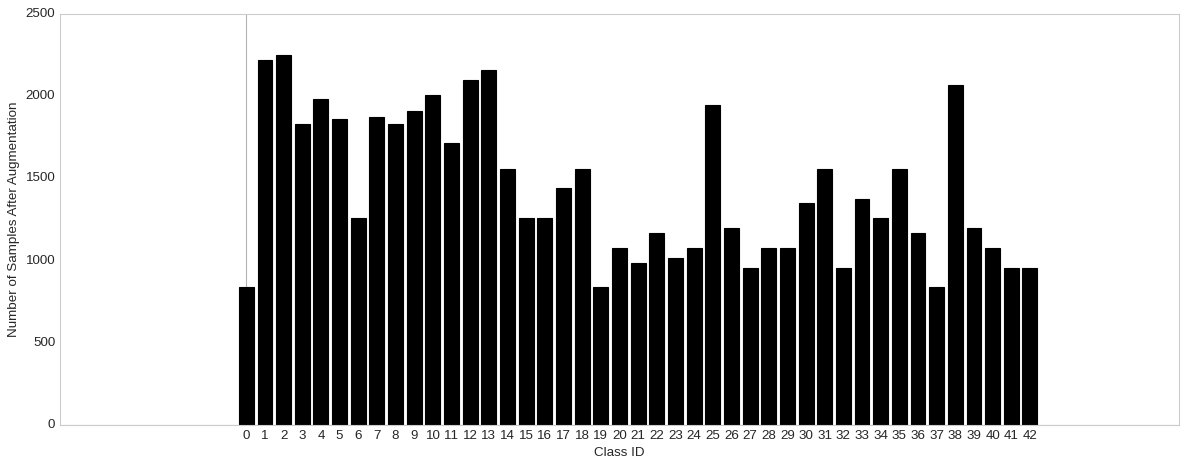

In [ ]:
# Cell 4: Execute data loading and augmentation
# Set random seed for reproducibility
np.random.seed(42)

# Load and augment the dataset
X_train, y_train, X_test, y_test = load_balanced_dataset()

# Save the processed dataset to avoid reprocessing
print("Saving processed dataset...")
np.save('X_train_augmented.npy', X_train)
np.save('y_train_augmented.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
print("Dataset saved.")

# Visualize class distribution after augmentation - black and white version
plt.figure(figsize=(15, 6))
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Sort by class ID for visualization
sort_idx = np.argsort(unique_classes)
unique_classes = unique_classes[sort_idx]
class_counts = class_counts[sort_idx]

# Create black bars with no transparency
plt.bar(unique_classes, class_counts, color='black', edgecolor='black')

# Set labels
plt.xlabel('Class ID')
plt.ylabel('Number of Samples After Augmentation')

# Remove grid and add only x and y axis
plt.grid(False)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Set x-ticks to class IDs
plt.xticks(unique_classes)

# Apply tight layout
plt.tight_layout()

# Save and show
plt.savefig('gtsrb_class_distribution_after_augmentation.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 5: Analyze augmentation results
# Load class information
class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at intersection", 12: "Priority road", 13: "Yield", 14: "Stop",
    15: "No vehicles", 16: "Vehicles over 3.5 tons prohibited", 17: "No entry",
    18: "General caution", 19: "Dangerous curve left", 20: "Dangerous curve right",
    21: "Double curve", 22: "Bumpy road", 23: "Slippery road", 24: "Road narrows on the right",
    25: "Road work", 26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead", 34: "Turn left ahead",
    35: "Ahead only", 36: "Go straight or right", 37: "Go straight or left", 38: "Keep right",
    39: "Keep left", 40: "Roundabout mandatory", 41: "End of no passing",
    42: "End no passing veh > 3.5 tons"
}

# Original class distribution (before augmentation)
original_counts = {}
for c in range(43):
    prefix = os.path.join(train_path, f'{c:05d}/')
    gt_file = os.path.join(prefix, f'GT-{c:05d}.csv')
    gt_data = pd.read_csv(gt_file, sep=';')
    original_counts[c] = len(gt_data) - 1  # Subtract header

# Current class distribution (after augmentation)
unique_classes, augmented_counts = np.unique(y_train, return_counts=True)
augmented_counts_dict = {cls: count for cls, count in zip(unique_classes, augmented_counts)}

# Create comparison dataframe
comparison_data = []
for c in range(43):
    original = original_counts[c]
    augmented = augmented_counts_dict.get(c, 0)
    added = augmented - original

    # Determine which strategy was applied
    if original <= 300:
        strategy = "3 techniques per image"
        expected_added = original * 3
    elif original <= 450:
        strategy = "2 techniques per image"
        expected_added = original * 2
    elif original <= 780:
        strategy = "1 technique per image"
        expected_added = original
    elif original <= 1500:
        strategy = "1 technique for 30% of images"
        expected_added = int(original * 0.3)
    else:
        strategy = "No augmentation"
        expected_added = 0

    comparison_data.append({
        'class_id': c,
        'class_name': class_names[c],
        'original_count': original,
        'augmented_count': augmented,
        'added_samples': added,
        'strategy': strategy,
        'expected_added': expected_added
    })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display table
print("Augmentation Results Summary:")
print("-" * 100)
print(f"{'Class ID':<8}{'Class Name':<40}{'Original':<10}{'Strategy':<30}{'Added':<10}{'Final':<10}")
print("-" * 100)

for _, row in comparison_df.iterrows():
    print(f"{row['class_id']:<8}{row['class_name']:<40}{row['original_count']:<10}{row['strategy']:<30}{row['added_samples']:<10}{row['augmented_count']:<10}")

# Summary statistics
print("\nSummary Statistics:")
print(f"Total original samples: {sum(original_counts.values())}")
print(f"Total augmented samples: {len(y_train)}")
print(f"Total added samples: {len(y_train) - sum(original_counts.values())}")
print(f"Augmentation ratio: {len(y_train) / sum(original_counts.values()):.2f}x")

# Class imbalance analysis
print("\nClass Imbalance Analysis:")
original_min = min(original_counts.values())
original_max = max(original_counts.values())
augmented_min = min(augmented_counts)
augmented_max = max(augmented_counts)

print(f"Before augmentation: min={original_min}, max={original_max}, ratio={original_max/original_min:.1f}x")
print(f"After augmentation: min={augmented_min}, max={augmented_max}, ratio={augmented_max/augmented_min:.1f}x")
print(f"Imbalance reduction: {(1 - (augmented_max/augmented_min)/(original_max/original_min))*100:.1f}%")

Augmentation Results Summary:
----------------------------------------------------------------------------------------------------
Class IDClass Name                              Original  Strategy                      Added     Final     
----------------------------------------------------------------------------------------------------
0       Speed limit (20km/h)                    209       3 techniques per image        627       836       
1       Speed limit (30km/h)                    2219      No augmentation               0         2219      
2       Speed limit (50km/h)                    2249      No augmentation               0         2249      
3       Speed limit (60km/h)                    1409      1 technique for 30% of images 422       1831      
4       Speed limit (70km/h)                    1979      No augmentation               0         1979      
5       Speed limit (80km/h)                    1859      No augmentation               0         1859      
6    

In [ ]:
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def create_aykonet_model():
    """
    Create a GiordyNet model architecture using depthwise separable convolutions
    as described in the MobileNet paper.

    Following MobileNet's approach:
    - Standard convolutions are replaced by depthwise + pointwise convolutions
    - Each convolution is followed by BatchNorm and ReLU
    """
    model = Sequential([
        # Use power-of-2 channels
        Conv2D(8, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 1)),
        BatchNormalization(),
        ReLU(),

        # First DS block
        DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(16, kernel_size=(1, 1)),
        BatchNormalization(),
        ReLU(),  # 16x16

        # Second DS block
        DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(32, kernel_size=(1, 1)),
        BatchNormalization(),
        ReLU(),  # 8x8

        # Third DS block
        DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, kernel_size=(1, 1)),
        BatchNormalization(),
        ReLU(),  # 4x4

        # Final DS block to increase channels
        DepthwiseConv2D(kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, kernel_size=(1, 1)),
        BatchNormalization(),
        ReLU(),

        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(43, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# If you haven't loaded the data yet, uncomment and run the line below
# X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Create the model
aykonet = create_aykonet_model()
aykonet.summary()

# Generate a visualization of the model architecture
try:
    # Install graphviz if not already installed
    !apt-get install -y graphviz
    !pip install pydot

    # Plot the model and save the visualization
    plot_model(aykonet, to_file='aykonet_architecture.png',
               show_shapes=True, show_layer_names=True)

    # Display the image
    Image('aykonet_architecture.png')
except Exception as e:
    print(f"Could not create model visualization: {e}")
    print("Continuing without visualization...")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 16, 16, 8)      │            80 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 8, 8, 16)       │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_4              │ (None, 4, 4, 32)       │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 64)       │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 19,419 (75.86 KB)

 Trainable params: 18,683 (72.98 KB)

 Non-trainable params: 736 (2.88 KB)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Could not create model visualization: name 'plot_model' is not defined
Continuing without visualization...


In [ ]:
# Setup early stopping - using val_accuracy with patience=15
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=15,             # Wait for 15 epochs without improvement
    restore_best_weights=True,  # Restore model to best performance
    verbose=1,
    mode='max'               # We want to maximize accuracy
)

# Train the model
history = aykonet.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,              # Maximum number of epochs
    validation_split=0.2,    # Use 20% of training data for validation
    callbacks=[early_stopping],
    verbose=1
)

# Save the model
aykonet.save('aykonet_full.h5')

# Evaluate the model on test set
test_loss, test_acc = aykonet.evaluate(X_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

Epoch 1/50
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 86s 43ms/step - accuracy: 0.1303 - loss: 3.3424 - val_accuracy: 0.4823 - val_loss: 1.8164
Epoch 2/50
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.4889 - loss: 1.7422 - val_accuracy: 0.6889 - val_loss: 1.0980
Epoch 3/50
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.6493 - loss: 1.1802 - val_accuracy: 0.7603 - val_loss: 0.8484
Epoch 4/50
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 79s 37ms/step - accuracy: 0.7365 - loss: 0.8961 - val_accuracy: 0.8182 - val_loss: 0.6368
Epoch 5/50
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.7853 - loss: 0.7378 - val_accuracy: 0.8439 - val_loss: 0.5299
Epoch 6/50
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.8127 - loss: 0.6195 - val_accuracy: 0.8640 - val_loss: 0.4454
Epoch 7/50
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.8416 - loss: 0.5353 - val_accuracy: 0.8601 - val_loss: 0.4503
Epoch 8/50
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.8513 -

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9327 - loss: 0.2520

Test accuracy: 93.34%


In [ ]:
# Convert to TFLite format (float32 - no quantization)
print("Converting model to TFLite format (float32)...")
converter = tf.lite.TFLiteConverter.from_keras_model(aykonet)
tflite_float_model = converter.convert()

# Save the float model
with open('giordynet_float.tflite', 'wb') as f:
    f.write(tflite_float_model)
print(f"Float TFLite model size: {len(tflite_float_model) / 1024:.2f} KB")

# Check model details
interpreter = tf.lite.Interpreter(model_content=tflite_float_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output type: {output_details[0]['dtype']}")

Converting model to TFLite format (float32)...
Saved artifact at '/tmp/tmp05py7wmx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  134349547609680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547608528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547608720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547607760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547611216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547608336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547607568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547605456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547605648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547607184: TensorSpec(shape=(

In [ ]:
# Integer-Only Quantization (everything quantized)
print("Converting model using Integer-Only Quantization...")
# Define representative dataset function for quantization
def representative_data_gen():
    for i in range(min(500, len(X_train))):
        sample = X_train[i]  # shape: (H, W) or (H, W, C)
        if sample.ndim == 2:
            sample = np.expand_dims(sample, axis=-1)  # add channel dim
        sample = np.expand_dims(sample, axis=0).astype(np.float32)  # add batch dim
        yield [sample]

converter = tf.lite.TFLiteConverter.from_keras_model(aykonet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_integer_only = converter.convert()

# Save the integer-only model
with open('giordynet_integer_only.tflite', 'wb') as f:
    f.write(tflite_integer_only)
print(f"Integer-only model size: {len(tflite_integer_only) / 1024:.2f} KB")

# Check model details
interpreter = tf.lite.Interpreter(model_content=tflite_integer_only)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output type: {output_details[0]['dtype']}")

Converting model using Integer-Only Quantization...
Saved artifact at '/tmp/tmp2dklmu0p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  134349547609680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547608528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547608720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547607760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547611216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547608336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547607568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547605456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547605648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134349547607184: TensorSpec(sh

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Integer-only model size: 36.80 KB
Input type: <class 'numpy.int8'>
Output type: <class 'numpy.int8'>


In [ ]:
# Import time for timing measurements
import time

# Define evaluation function for quantized models
def evaluate_tflite_model(tflite_model, model_name, num_test_samples=1000):
    """Evaluate a TFLite model on the test set"""
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print(f"\nEvaluating {model_name} on {num_test_samples} test samples:")
    input_type = input_details[0]['dtype']
    output_type = output_details[0]['dtype']

    # Get quantization parameters if available
    input_scale = input_details[0]['quantization'][0]
    input_zero_point = input_details[0]['quantization'][1]
    output_scale = output_details[0]['quantization'][0]
    output_zero_point = output_details[0]['quantization'][1]
    has_input_quant = input_scale != 0  # If scale is 0, quantization is not applied
    has_output_quant = output_scale != 0

    if has_input_quant:
        print(f"Input quantization: scale={input_scale}, zero_point={input_zero_point}")
    if has_output_quant:
        print(f"Output quantization: scale={output_scale}, zero_point={output_zero_point}")

    # Only use as many samples as we have in the test set
    num_test_samples = min(num_test_samples, len(X_test))

    # Test on multiple examples
    correct = 0
    total_inference_time = 0  # Track only inference time

    for i in tqdm(range(num_test_samples)):
        # Prepare input tensor
        test_image = X_test[i]
        true_class = y_test[i]

        if test_image.ndim == 2:
            test_image = np.expand_dims(test_image, axis=-1)  # Add channel dim if needed
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)  # Add batch dim

        if input_type == np.int8 and has_input_quant:
            test_image = test_image / input_scale + input_zero_point
            test_image = np.clip(test_image, -128, 127).astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], test_image)

        # Measure ONLY the inference time
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()

        # Accumulate the inference time
        total_inference_time += (end_time - start_time)

        # Get output
        output = interpreter.get_tensor(output_details[0]['index'])

        # If output is quantized, dequantize it
        if output_type == np.int8 and has_output_quant:
            output = (output.astype(np.float32) - output_zero_point) * output_scale

        # Get predicted class
        predicted_class = np.argmax(output)

        if predicted_class == true_class:
            correct += 1

    # Calculate metrics
    accuracy = correct / num_test_samples
    avg_inference_time = total_inference_time / num_test_samples  # Average inference time per sample

    print(f"Final accuracy on {num_test_samples} test samples: {accuracy*100:.2f}%")
    print(f"Total inference time: {total_inference_time:.4f} seconds")
    print(f"Average inference time per sample: {avg_inference_time*1000:.4f} ms")

    return accuracy, avg_inference_time

In [ ]:
# Evaluate both models
print("Evaluating both models on test dataset...")
num_test_samples = 1000  # Adjust based on your computational resources

# Evaluate float model
accuracy_float, time_float = evaluate_tflite_model(
    tflite_float_model, "Float model (baseline)", num_test_samples)

# Evaluate integer-only model
accuracy_int, time_int = evaluate_tflite_model(
    tflite_integer_only, "Integer-only quantization", num_test_samples)

# Print comparison summary
print("\nModel Comparison Summary:")
print("-" * 80)
print(f"{'Model Type':<25} | {'Size (KB)':<10} | {'Accuracy (%)':<12} | {'Inference Time (ms)':<20}")
print("-" * 80)
print(f"{'Float (baseline)':<25} | {len(tflite_float_model)/1024:<10.2f} | {accuracy_float*100:<12.2f} | {time_float*1000:<20.2f}")
print(f"{'Integer-only':<25} | {len(tflite_integer_only)/1024:<10.2f} | {accuracy_int*100:<12.2f} | {time_int*1000:<20.2f}")
print("-" * 80)

# Calculate size reduction and speedup
size_reduction = (1 - len(tflite_integer_only)/len(tflite_float_model)) * 100
speedup = time_float / time_int
accuracy_loss = (accuracy_float - accuracy_int) * 100

print(f"\nQuantization Benefits:")
print(f"Size reduction: {size_reduction:.2f}%")
print(f"Speedup: {speedup:.2f}x")
print(f"Accuracy loss: {accuracy_loss:.2f}%")

Evaluating both models on test dataset...

Evaluating Float model (baseline) on 1000 test samples:


100%|██████████| 1000/1000 [00:00<00:00, 21313.06it/s]


Final accuracy on 1000 test samples: 94.00%
Total inference time: 0.0332 seconds
Average inference time per sample: 0.0332 ms

Evaluating Integer-only quantization on 1000 test samples:
Input quantization: scale=0.003921568859368563, zero_point=-128
Output quantization: scale=0.00390625, zero_point=-128


100%|██████████| 1000/1000 [00:00<00:00, 10225.15it/s]

Final accuracy on 1000 test samples: 94.60%
Total inference time: 0.0627 seconds
Average inference time per sample: 0.0627 ms

Model Comparison Summary:
--------------------------------------------------------------------------------
Model Type                | Size (KB)  | Accuracy (%) | Inference Time (ms) 
--------------------------------------------------------------------------------
Float (baseline)          | 77.88      | 94.00        | 0.03                
Integer-only              | 36.80      | 94.60        | 0.06                
--------------------------------------------------------------------------------

Quantization Benefits:
Size reduction: 52.75%
Speedup: 0.53x
Accuracy loss: -0.60%


In [ ]:
# Generate C source file from the integer-only TFLite model
!xxd -i giordynet_integer_only.tflite > traffic_sign_model_data.cc

# Check the file size
!ls -lh traffic_sign_model_data.cc

-rw-r--r-- 1 root root 228K Jun 16 14:14 traffic_sign_model_data.cc


Test data loaded successfully!
Model Information:
Input shape: [ 1 32 32  1]
Input type: <class 'numpy.int8'>
Output shape: [ 1 43]
Output type: <class 'numpy.int8'>

Quantization Parameters:
Input - Scale: 0.003921568859368563, Zero Point: -128
Output - Scale: 0.00390625, Zero Point: -128

Evaluating on 1000 test samples...


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 11589.16it/s]


            INT8 QUANTIZED MODEL EVALUATION RESULTS
Total Test Samples:           1000
Correct Predictions:          943
Accuracy:                     94.30%
Total Inference Time:         0.0613 seconds
Average Inference Time:       0.06 ms per sample

------------------------------------------------------------
PERFORMANCE ANALYSIS:
Frames per Second (FPS):      16313.2
Real-time Performance:       ✓ Suitable for real-time applications

            DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0      0.857     0.600     0.706        10
     Class 1      0.966     0.905     0.934        63
     Class 2      0.981     0.981     0.981        52
     Class 3      0.974     0.927     0.950        41
     Class 4      0.944     0.927     0.936        55
     Class 5      0.956     0.977     0.966        44
     Class 6      0.923     0.923     0.923        13
     Class 7      0.971     1.000     0.986        34
     Class 8      0.867    

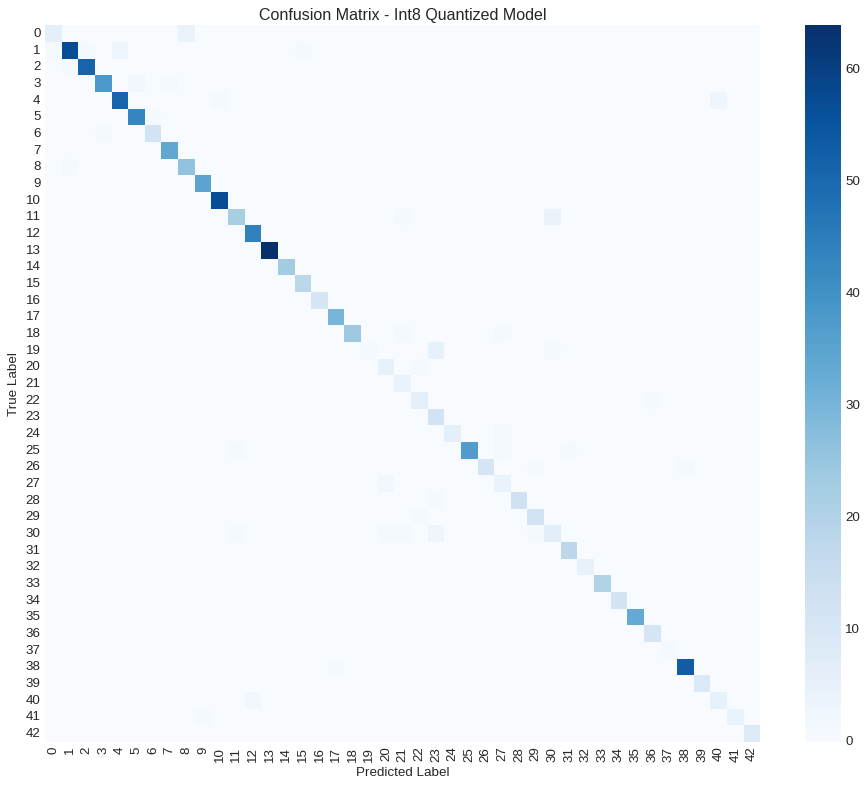

In [ ]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_int8_tflite_model(model_path, X_test, y_test, num_samples=1000):
    """
    Evaluate an int8 quantized TensorFlow Lite model on test data.

    Args:
        model_path: Path to the .tflite model file
        X_test: Test images (numpy array)
        y_test: Test labels (numpy array)
        num_samples: Number of test samples to evaluate (default: 1000)

    Returns:
        Dictionary containing evaluation results
    """

    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("Model Information:")
    print(f"Input shape: {input_details[0]['shape']}")
    print(f"Input type: {input_details[0]['dtype']}")
    print(f"Output shape: {output_details[0]['shape']}")
    print(f"Output type: {output_details[0]['dtype']}")

    # Get quantization parameters
    input_scale = input_details[0]['quantization'][0]
    input_zero_point = input_details[0]['quantization'][1]
    output_scale = output_details[0]['quantization'][0]
    output_zero_point = output_details[0]['quantization'][1]

    print(f"\nQuantization Parameters:")
    print(f"Input - Scale: {input_scale}, Zero Point: {input_zero_point}")
    print(f"Output - Scale: {output_scale}, Zero Point: {output_zero_point}")

    # Limit the number of samples
    num_samples = min(num_samples, len(X_test))
    print(f"\nEvaluating on {num_samples} test samples...")

    # Initialize tracking variables
    correct_predictions = 0
    total_inference_time = 0
    predictions = []
    true_labels = []

    # Process each test sample
    for i in tqdm(range(num_samples), desc="Evaluating"):
        # Get test image and true label
        test_image = X_test[i:i+1]  # Keep batch dimension
        true_label = y_test[i]

        # Quantize the input image
        # X_test is already normalized to [0,1], so we need to apply quantization
        quantized_input = test_image / input_scale + input_zero_point
        quantized_input = np.clip(quantized_input, -128, 127).astype(np.int8)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], quantized_input)

        # Measure inference time
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()

        # Accumulate inference time
        total_inference_time += (end_time - start_time)

        # Get output
        output = interpreter.get_tensor(output_details[0]['index'])

        # Dequantize output if needed
        if output_details[0]['dtype'] == np.int8:
            output = (output.astype(np.float32) - output_zero_point) * output_scale

        # Get predicted class
        predicted_class = np.argmax(output[0])

        # Track predictions
        predictions.append(predicted_class)
        true_labels.append(true_label)

        # Check if prediction is correct
        if predicted_class == true_label:
            correct_predictions += 1

    # Calculate metrics
    accuracy = correct_predictions / num_samples
    avg_inference_time = total_inference_time / num_samples

    # Create results dictionary
    results = {
        'accuracy': accuracy,
        'total_samples': num_samples,
        'correct_predictions': correct_predictions,
        'total_inference_time': total_inference_time,
        'avg_inference_time_ms': avg_inference_time * 1000,
        'predictions': np.array(predictions),
        'true_labels': np.array(true_labels)
    }

    return results

def print_evaluation_results(results):
    """Print evaluation results in a formatted way."""

    print("\n" + "="*60)
    print("            INT8 QUANTIZED MODEL EVALUATION RESULTS")
    print("="*60)

    print(f"Total Test Samples:           {results['total_samples']}")
    print(f"Correct Predictions:          {results['correct_predictions']}")
    print(f"Accuracy:                     {results['accuracy']*100:.2f}%")
    print(f"Total Inference Time:         {results['total_inference_time']:.4f} seconds")
    print(f"Average Inference Time:       {results['avg_inference_time_ms']:.2f} ms per sample")

    print("\n" + "-"*60)
    print("PERFORMANCE ANALYSIS:")

    # Calculate FPS
    fps = 1.0 / (results['avg_inference_time_ms'] / 1000)
    print(f"Frames per Second (FPS):      {fps:.1f}")

    # Real-time performance indicator
    if results['avg_inference_time_ms'] < 33.33:  # 30 FPS threshold
        print("Real-time Performance:       ✓ Suitable for real-time applications")
    elif results['avg_inference_time_ms'] < 100:
        print("Real-time Performance:       ~ Moderate real-time capability")
    else:
        print("Real-time Performance:       ✗ Not suitable for real-time applications")

def plot_confusion_matrix(results, class_names=None):
    """Plot confusion matrix for the evaluation results."""

    cm = confusion_matrix(results['true_labels'], results['predictions'])

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Int8 Quantized Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    if class_names:
        plt.xticks(range(len(class_names)), class_names, rotation=45)
        plt.yticks(range(len(class_names)), class_names, rotation=0)

    plt.tight_layout()
    plt.show()

def detailed_classification_report(results):
    """Print detailed classification report."""

    print("\n" + "="*60)
    print("            DETAILED CLASSIFICATION REPORT")
    print("="*60)

    report = classification_report(
        results['true_labels'],
        results['predictions'],
        target_names=[f"Class {i}" for i in range(43)],
        digits=3
    )
    print(report)

# Main evaluation function
def run_complete_evaluation():
    """Run complete evaluation of the int8 quantized model."""

    # Load your test data (modify paths as needed)
    try:
        X_test = np.load('X_test.npy')
        y_test = np.load('y_test.npy')
        print("Test data loaded successfully!")
    except FileNotFoundError:
        print("Error: Test data files not found. Please ensure X_test.npy and y_test.npy exist.")
        return

    # Path to your quantized model
    model_path = 'giordynet_integer_only.tflite'  # Adjust path as needed

    try:
        # Run evaluation
        results = evaluate_int8_tflite_model(model_path, X_test, y_test, num_samples=1000)

        # Print results
        print_evaluation_results(results)

        # Print detailed classification report
        detailed_classification_report(results)

        # Plot confusion matrix
        plot_confusion_matrix(results)

        return results

    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found.")
        return None
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return None

# GTSRB Class names for better interpretation
GTSRB_CLASS_NAMES = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing veh over 3.5 tons",
    11: "Right-of-way at intersection", 12: "Priority road", 13: "Yield", 14: "Stop",
    15: "No vehicles", 16: "Veh > 3.5 tons prohibited", 17: "No entry",
    18: "General caution", 19: "Dangerous curve left", 20: "Dangerous curve right",
    21: "Double curve", 22: "Bumpy road", 23: "Slippery road", 24: "Road narrows on the right",
    25: "Road work", 26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End speed + passing limits", 33: "Turn right ahead", 34: "Turn left ahead",
    35: "Ahead only", 36: "Go straight or right", 37: "Go straight or left", 38: "Keep right",
    39: "Keep left", 40: "Roundabout mandatory", 41: "End of no passing",
    42: "End no passing veh > 3.5 tons"
}

results = run_complete_evaluation()

In [ ]:
# Load the model from file
with open('giordynet_integer_only.tflite', 'rb') as f:
    model_content = f.read()

# Print model size in kilobytes
print(f"Model size: {len(model_content) / 1024:.2f} KB")


Model size: 36.80 KB
